In [2]:
import pandas as pd
import numpy as np

In [3]:
%pwd

'/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/src/analysis/round4'

In [4]:
%cd ../../../data/round4/preprocessed

/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/data/round4/preprocessed


In [5]:
%ls

mid_price_day0.csv  mid_price_day1.csv  mid_price_day2.csv  mid_price_day3.csv


In [7]:
df_mid_0 = pd.read_csv('mid_price_day0.csv')
df_mid_1 = pd.read_csv('mid_price_day1.csv')
df_mid_2 = pd.read_csv('mid_price_day2.csv')
df_mid_3 = pd.read_csv('mid_price_day3.csv')

In [8]:
df_mid_0['T'] = (7 - df_mid_0['timestamp'] * 0.0001 / 100  ) / 365
df_mid_1['T'] = (6 - df_mid_1['timestamp'] * 0.0001 / 100  ) / 365
df_mid_2['T'] = (5 - df_mid_2['timestamp'] * 0.0001 / 100  ) / 365
df_mid_3['T'] = (4 - df_mid_3['timestamp'] * 0.0001 / 100  ) / 365

In [9]:
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import numpy as np

def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def implied_volatility(S, K, T, r, market_price):
    loss_fn = lambda sigma: (bs_call_price(S, K, T, r, sigma) - market_price)**2
    result = minimize_scalar(loss_fn, bounds=(1e-4, 3.0), method='bounded')
    return result.x

def calculate_iv(df):
    df = df.copy()
    strick_prices = [9500, 9750, 10000, 10250, 10500]
    for strick_price in strick_prices:
        df['iv_' + str(strick_price)] = df.apply(lambda row: implied_volatility(
            row['VOLCANIC_ROCK'], strick_price, row['T'], 0, row['VOLCANIC_ROCK_VOUCHER_' + str(strick_price)]), axis=1)
    return df

def calculate_moneyness(df):
    df = df.copy()
    strike_prices = [9500, 9750, 10000, 10250, 10500]
    for strike in strike_prices:
        df[f'm_{strike}'] = df.apply(lambda row: np.log(strike / row['VOLCANIC_ROCK']) / np.sqrt(row['T']), axis=1)
    return df

def fit_iv_curve(df):
    """返回每个时间点 t 的 beta 系数（β₀, β₁, β₂），强制 β₂ ≥ 0"""
    betas = []

    for idx, row in df.iterrows():
        m_values = []
        iv_values = []

        for strike in [9500, 9750, 10000, 10250, 10500]:
            m = row[f'm_{strike}']
            iv = row[f'iv_{strike}']
            if 0 < iv < 2:  # 排除极端值
                m_values.append(m)
                iv_values.append(iv)

        if len(m_values) >= 3:
            # 第一次完整拟合
            X_full = np.column_stack([np.ones(len(m_values)), 
                                    m_values, 
                                    np.square(m_values)])
            beta = np.linalg.lstsq(X_full, iv_values, rcond=None)[0]
            
            # 如果 β₂ < 0，则回退到受限拟合
            if beta[2] < 0:
                X_restrict = np.column_stack([np.ones(len(m_values)),
                                            np.square(m_values)])
                beta_restrict = np.linalg.lstsq(X_restrict, iv_values, rcond=None)[0]
                
                # 强制 β₂ ≥ 1e-6 (接近零的小正数)
                beta_2 = max(beta_restrict[1], 1e-6)
                beta = [beta_restrict[0], 0.0, beta_2]  # β₁ 设为 0
                
        else:
            beta = [np.nan, np.nan, np.nan]

        betas.append(beta)

    df[['beta_0', 'beta_1', 'beta_2']] = pd.DataFrame(betas, index=df.index)
    return df


def add_fitted_ivs(df, strike_prices=[9500, 9750, 10000, 10250, 10500]):
    df = df.copy()
    for strike in strike_prices:
        m_col = f'm_{strike}'
        fitted_col = f'fitted_iv_{strike}'
        df[fitted_col] = df.apply(
            lambda row: row['beta_0'] + row['beta_1'] * row[m_col] + row['beta_2'] * row[m_col]**2
            if not np.isnan(row['beta_0']) and not np.isnan(row[m_col]) else np.nan,
            axis=1
        )
    return df

def calculate_base_iv(df):
    df['base_iv'] = df['beta_0']  # 因为在 m = 0 时，β₁·m + β₂·m² 都为0
    return df

In [10]:
def preprocess(df):
    df = df.copy()
    df = calculate_iv(df)
    df = calculate_moneyness(df)
    df = fit_iv_curve(df)
    df = add_fitted_ivs(df)
    df = calculate_base_iv(df)
    return df

In [11]:
df_mid_0 = preprocess(df_mid_0)
df_mid_1 = preprocess(df_mid_1)
df_mid_2 = preprocess(df_mid_2)
df_mid_3 = preprocess(df_mid_3)
df_mid_0.to_csv('day0.csv', index=False)
df_mid_1.to_csv('day1.csv', index=False)
df_mid_2.to_csv('day2.csv', index=False)
df_mid_3.to_csv('day3.csv', index=False)

In [13]:
df_mid_1

,timestamp,day,VOLCANIC_ROCK,VOLCANIC_ROCK_VOUCHER_9500,VOLCANIC_ROCK_VOUCHER_9750,VOLCANIC_ROCK_VOUCHER_10000,VOLCANIC_ROCK_VOUCHER_10250,VOLCANIC_ROCK_VOUCHER_10500,T,iv_9500,...,m_10500,beta_0,beta_1,beta_2,fitted_iv_9500,fitted_iv_9750,fitted_iv_10000,fitted_iv_10250,fitted_iv_10500,base_iv
0,0,1,10516.0,1016.0,766.5,517.5,279.5,95.5,0.016438,0.081794,...,-0.011876,0.190137,0.000000,0.000001,0.190138,0.190137,0.190137,0.190137,0.190137,0.190137
1,100,1,10515.0,1015.5,765.5,516.5,278.5,94.5,0.016438,0.300232,...,-0.011134,0.164007,0.048355,0.276766,0.299217,0.231583,0.187527,0.165350,0.163503,0.164007
2,200,1,10515.0,1015.5,765.5,516.5,278.5,94.5,0.016438,0.300234,...,-0.011134,0.164008,0.048355,0.276764,0.299220,0.231585,0.187528,0.165351,0.163504,0.164008
3,300,1,10517.0,1017.5,767.5,519.5,280.5,95.5,0.016438,0.300734,...,-0.012618,0.162297,0.000512,0.216707,0.298252,0.237595,0.195595,0.170913,0.162325,0.162297
4,400,1,10519.5,1019.5,770.5,521.5,282.5,97.5,0.016437,0.081980,...,-0.014472,0.194633,0.000000,0.000001,0.194634,0.194633,0.194633,0.194633,0.194633,0.194633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,999500,1,10224.5,725.5,476.5,237.5,66.5,9.5,0.013700,0.268090,...,0.227161,0.160572,0.003742,0.275953,0.267022,0.204537,0.169791,0.160776,0.175662,0.160572
9996,999600,1,10225.5,725.5,477.5,237.5,66.5,9.5,0.013700,0.070751,...,0.226327,0.185440,0.000000,0.000001,0.185440,0.185440,0.185440,0.185440,0.185440,0.185440
9997,999700,1,10222.0,722.5,472.5,234.5,64.5,9.5,0.013699,0.246240,...,0.229254,0.154998,0.043547,0.284831,0.239304,0.183876,0.156853,0.156171,0.179951,0.154998
9998,999800,1,10223.5,723.5,474.5,237.5,65.5,9.5,0.013699,0.070611,...,0.228003,0.184792,0.000000,0.000001,0.184793,0.184793,0.184792,0.184792,0.184792,0.184792


In [14]:
df0 = pd.read_csv('day0.csv')
df1 = pd.read_csv('day1.csv')
df1['timestamp'] = df1['timestamp'] + 1000000
df2 = pd.read_csv('day2.csv')
df2['timestamp'] = df2['timestamp'] + 2000000
df3 = pd.read_csv('day3.csv')
df3['timestamp'] = df3['timestamp'] + 3000000
df = pd.concat([df0, df1, df2, df3], ignore_index=True)


In [15]:
df

,timestamp,VOLCANIC_ROCK,VOLCANIC_ROCK_VOUCHER_9500,VOLCANIC_ROCK_VOUCHER_9750,VOLCANIC_ROCK_VOUCHER_10000,VOLCANIC_ROCK_VOUCHER_10250,VOLCANIC_ROCK_VOUCHER_10500,T,iv_9500,iv_9750,...,beta_0,beta_1,beta_2,fitted_iv_9500,fitted_iv_9750,fitted_iv_10000,fitted_iv_10250,fitted_iv_10500,base_iv,day
0,0,10503.0,1003.5,754.5,505.5,273.5,99.5,0.019178,0.275176,0.240593,...,0.167754,0.010478,0.227549,0.279688,0.227791,0.192617,0.172963,0.167733,0.167754,NaN
1,100,10510.0,1010.5,761.5,515.5,279.5,102.5,0.019178,0.276801,0.242447,...,0.163705,-0.088029,0.095618,0.278825,0.239508,0.207660,0.182756,0.164314,0.163705,NaN
2,200,10513.0,1013.5,764.5,516.5,282.5,104.5,0.019178,0.277498,0.243241,...,0.166235,-0.034411,0.167288,0.280962,0.234478,0.200498,0.178129,0.166556,0.166235,NaN
3,300,10517.5,1018.0,768.5,521.5,285.5,106.5,0.019177,0.278542,0.231938,...,0.166232,-0.025222,0.174314,0.278867,0.232222,0.198561,0.176957,0.166560,0.166232,NaN
4,400,10509.5,1010.0,760.5,512.5,279.5,102.5,0.019177,0.276691,0.229910,...,0.168775,0.012014,0.220900,0.277490,0.227083,0.192910,0.173806,0.168706,0.168775,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,3999500,9916.0,417.5,181.5,34.5,2.5,1.0,0.008221,0.230461,0.193793,...,0.182399,-0.000404,0.225924,0.233070,0.190307,0.184317,0.212413,0.272144,0.182399,3.0
39996,3999600,9917.0,418.5,182.5,30.5,2.5,1.0,0.008220,0.230923,0.194537,...,0.176151,-0.005038,0.251133,0.234917,0.185906,0.177810,0.207641,0.272671,0.176151,3.0
39997,3999700,9917.5,419.5,182.5,34.5,2.5,1.0,0.008220,0.241802,0.192660,...,0.181001,-0.012104,0.250497,0.243113,0.192117,0.181986,0.209738,0.272650,0.181001,3.0
39998,3999800,9919.0,420.0,184.5,33.5,2.5,1.0,0.008220,0.218555,0.196022,...,0.180246,0.009677,0.211698,0.223615,0.186017,0.182818,0.211501,0.269774,0.180246,3.0


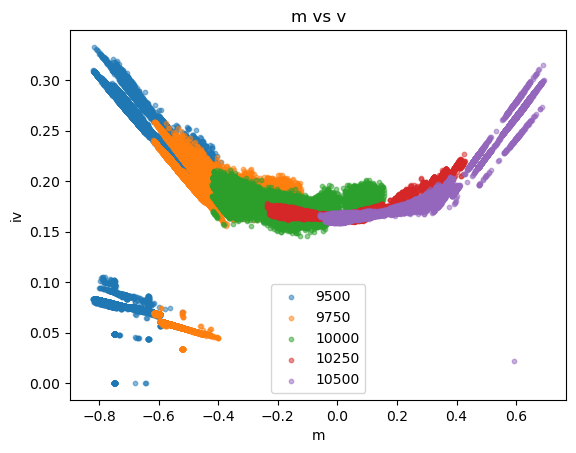

In [16]:
#画出m, iv散点图
import pandas as pd
import matplotlib.pyplot as plt

plt.scatter(df['m_9500'], df['iv_9500'], s=10, alpha=0.5, label = '9500')
plt.scatter(df['m_9750'], df['iv_9750'], s=10, alpha=0.5, label = '9750')
plt.scatter(df['m_10000'], df['iv_10000'], s=10, alpha=0.5, label = '10000')
plt.scatter(df['m_10250'], df['iv_10250'], s=10, alpha=0.5, label = '10250')
plt.scatter(df['m_10500'], df['iv_10500'], s=10, alpha=0.5, label = '10500')
plt.title('m vs v')
plt.xlabel('m')
plt.ylabel('iv')
plt.legend()
plt.show()

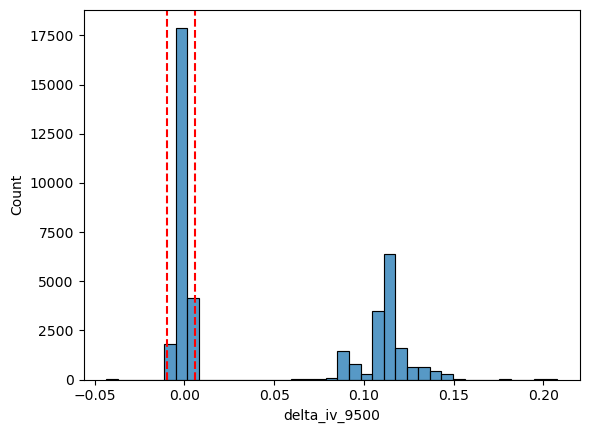

In [18]:
df['delta_iv_9500'] = df['fitted_iv_9500'] - df['iv_9500']
import seaborn as sns
sns.histplot(df['delta_iv_9500'])
plt.axvline(x = 0.006, color='r', linestyle='--')
plt.axvline(x = -0.01, color='r', linestyle='--')

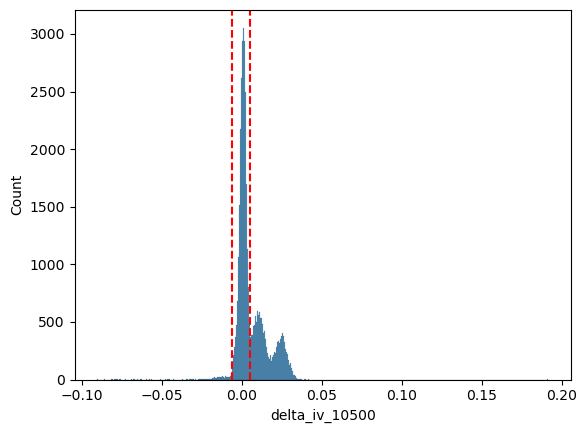

In [17]:
df['delta_iv_10500'] = df['fitted_iv_10500'] - df['iv_10500']
import seaborn as sns
sns.histplot(df['delta_iv_10500'])
plt.axvline(x = 0.005, color='r', linestyle='--')
plt.axvline(x = -0.006, color='r', linestyle='--')